# Setup

In [1]:
import os
import sys
import subprocess
import math
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import scipy as sp

import anndata as ad
import scanpy as sc

### User variables

In [2]:
cell_type = str("DL-EN")
CT_MAP_JSON_PATH = "config/cell-type_groupings/hca_brain-organoids/approach_2024-09-12.json"

RUN_ID = "meqtl_sep30_ref2_approach_2024-09-12"
DATASET_ID = "hca_brain-organoids"

In [3]:
PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
HCA_BORGS_PROJ = "data/datasets/hca_brain-organoids/"
ATAC_PEAKS_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss.h5ad")
RNA_AD_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids/outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad")

In [4]:
bedtools_bin = '/home/fichtner/.conda/envs/ian/bin/bedtools'

In [5]:
min_cells = 10 # All cts: cell-level | Minimum amount of cells a peak needs to for the peak to be retained (required for functions to work)

n_top_hvps = 10000 # 1 ct: cell-level | Top n ranked peaks to consider in highly-variable-peaks
min_mean_acells = 0.0125
max_mean_acells = 2

min_pval = 0.01 # Min p-value for marker peaks to be considered in the first place in differential peak accessibility
n_top_markers = 10000 # All cts: donor-level (cell agg.) | Top n ranking markers peaks to consider

min_mean_adonors = 0.002
min_donors = 0.24
min_score = 0.8

n_ca_PCs = 5 # Nr of chromatin accessibility PCs used as covariate

### Variables

In [6]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt, create_folder

In [7]:
cell_type_alt = ct_format_alt(cell_type)
cell_type = ct_format(cell_type)

In [8]:
ct_map_id = os.path.basename(CT_MAP_JSON_PATH).split('.')[0]

# Get ct-ann --> grouped-ct mappings
with open(CT_MAP_JSON_PATH, 'r') as f:
    ct_map = json.load(f)

# Format
ct_map_alt = {ct_format_alt(key): [ct_format_alt(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i_alt = {ct_format_alt(old_ct): ct_format_alt(new_ct) for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

ct_map = {ct_format(key): [ct_format(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i = {old_ct: new_ct for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

### Artifact donors

In [9]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [10]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# Get data

## Chromatin accessibility cell-level anndata

In [11]:
borgs_tile_mat = ad.read_h5ad(ATAC_PEAKS_PATH)

# Format
borgs_tile_mat.var_names = borgs_tile_mat.var['peak_name']
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].apply(ct_format)
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].map(ct_map_i).astype('category')

# Filter cell-types marked 'Discard'
if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
    borgs_tile_mat = borgs_tile_mat[~(borgs_tile_mat.obs['cell_type'] == 'Discard'), :].copy()
    
    if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
        borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].cat.remove_categories('Discard')

print(borgs_tile_mat.obs['cell_type'].cat.categories)
borgs_tile_mat

Index(['DL-EN', 'Glia', 'Midbrain-EN', 'Neural-progenitors', 'UL-EN'], dtype='object')


AnnData object with n_obs × n_vars = 199379 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [12]:
borgs_tile_mat.obs['cell_type']

index_name
CCTAAATCACATAACT-1_sSL0163                  UL-EN
GCTGCAATCCTTAGTT-1_sSL0108                  UL-EN
AGTCTTGCAGGCGAGT-1_sSL0161                   Glia
TGACTTAAGTAATCCA-1_sSL0113A    Neural-progenitors
CAATGTGGTTGAGGTC-1_sSL0149                  UL-EN
                                      ...        
TGTTATGAGAAGGTGC-1_sSL0112A                 DL-EN
CATTGTAAGTTAGGCT-1_sSL0089                   Glia
AGGTCTTAGTTAGTTG-1_sSL0099     Neural-progenitors
CGAGCTGGTCACAAAT-1_sSL0112A                 UL-EN
GTTACGTAGATAGACG-1_sSL0093            Midbrain-EN
Name: cell_type, Length: 199379, dtype: category
Categories (5, object): ['DL-EN', 'Glia', 'Midbrain-EN', 'Neural-progenitors', 'UL-EN']

In [13]:
# Remove artifact donors
donors_qc = ~borgs_tile_mat.obs['donor_id'].isin(artifact_donors)

borgs_tile_mat = borgs_tile_mat[donors_qc, :].copy()

borgs_tile_mat.shape

(195931, 736845)

### Get cell-type anndata

In [14]:
caPeaks_1ct = borgs_tile_mat[borgs_tile_mat.obs['cell_type'] == cell_type, :].copy()
caPeaks_1ct

AnnData object with n_obs × n_vars = 30210 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [15]:
n_peaks_og = caPeaks_1ct.n_vars

In [16]:
caPeaks_1ct.obs['cell_type'].cat.categories

Index(['DL-EN'], dtype='object')

### Hard peak filter: Remove peaks w min cell nr within ct

In [17]:
# Required for HVPeaks
sc.pp.filter_genes(caPeaks_1ct, min_cells=min_cells)
n_cells, n_peaks_post_min_cells = caPeaks_1ct.shape
caPeaks_1ct.shape

(30210, 732753)

In [18]:
n_peaks_min_cells = n_peaks_og - n_peaks_post_min_cells

In [19]:
# Remove hard-filtered peaks from cell-level anndata
borgs_tile_mat = borgs_tile_mat[:, caPeaks_1ct.var_names].copy()

### Cell-type cells level stats

In [20]:
# describe_result = sp.stats.describe(caPeaks_1ct.X.toarray(), axis=0)

# stats = {
#     'nobs': [describe_result.nobs] * len(describe_result.mean),
#     'min': describe_result.minmax[0],
#     'max': describe_result.minmax[1],
#     'mean': describe_result.mean,
#     'variance': describe_result.variance,
#     'skewness': describe_result.skewness,
#     'kurtosis': describe_result.kurtosis
# }

# # Create a DataFrame with the statistics
# df = pd.DataFrame(stats)
# df = df.transpose().reset_index().rename(columns={'index': 'statistic'}).set_index('statistic')

# df

### Init donor-level CA matrix

In [21]:
caPeaks_1ct_agg = sc.get.aggregate(caPeaks_1ct,
                                   by=['donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_1ct_agg.X = caPeaks_1ct_agg.layers['mean'].copy()
del caPeaks_1ct_agg.layers['mean']

n_donors = caPeaks_1ct_agg.n_obs

caPeaks_1ct_agg

AnnData object with n_obs × n_vars = 66 × 732753
    obs: 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type', 'n_cells'

In [22]:
agg_df = caPeaks_1ct_agg.to_df()
agg_df

peak_name,chr1:804695:805195:501:*:1,chr1:811018:811518:501:*:2,chr1:817077:817577:501:*:3,chr1:817816:818316:501:*:4,chr1:819782:820282:501:*:5,chr1:826617:827117:501:*:6,chr1:827319:827819:501:*:7,chr1:830673:831173:501:*:8,chr1:838258:838758:501:*:9,chr1:849809:850309:501:*:10,...,chrX:155880442:155880942:501:*:19669,chrX:155881013:155881513:501:*:19670,chrX:155881586:155882086:501:*:19671,chrX:155888143:155888643:501:*:19672,chrX:155889305:155889805:501:*:19673,chrX:155891803:155892303:501:*:19674,chrX:155941826:155942326:501:*:19675,chrX:155956608:155957108:501:*:19676,chrX:155959222:155959722:501:*:19677,chrX:155966839:155967339:501:*:19678
SAMEA2420640,0.0,0.007400,0.007249,0.006098,0.000000,0.009910,0.073719,0.000000,0.000000,0.000000,...,0.000000,0.062547,0.000000,0.000000,0.000000,0.000000,0.007219,0.000000,0.000000,0.000000
SAMEA2433566,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2445779,0.0,0.008189,0.000961,0.000000,0.000000,0.007622,0.071930,0.001109,0.004716,0.000000,...,0.010973,0.083102,0.007546,0.002845,0.000000,0.011770,0.006998,0.006479,0.000000,0.001866
SAMEA2445784,0.0,0.001057,0.003073,0.000000,0.001309,0.016787,0.036761,0.000000,0.000839,0.000000,...,0.019317,0.078680,0.020910,0.010710,0.004738,0.026531,0.001359,0.000000,0.000000,0.000000
SAMEA2459959,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA3977051,0.0,0.002710,0.009693,0.001563,0.003036,0.009736,0.043403,0.000000,0.013961,0.003026,...,0.006596,0.102384,0.003775,0.009721,0.000498,0.015728,0.000000,0.001199,0.001831,0.001606
SAMEA4089453,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA4343052,0.0,0.007332,0.009675,0.000737,0.003164,0.010879,0.049869,0.000000,0.000000,0.000685,...,0.007855,0.072811,0.012433,0.005883,0.002846,0.014433,0.004712,0.000330,0.000691,0.000000
SAMEA4451098,0.0,0.000000,0.000000,0.004009,0.003173,0.007848,0.044345,0.003302,0.000000,0.001329,...,0.005780,0.086557,0.017961,0.001698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Init ct-donor-level CA matrix

In [23]:
caPeaks_agg_cd = sc.get.aggregate(borgs_tile_mat,
                                   by=['cell_type', 'donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_agg_cd.X = caPeaks_agg_cd.layers['mean'].copy()
del caPeaks_agg_cd.layers['mean']

caPeaks_agg_cd

AnnData object with n_obs × n_vars = 316 × 732753
    obs: 'cell_type', 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

### Init donor-batch-level CA matrix

In [24]:
# caPeaks_agg_cdb = sc.get.aggregate(borgs_tile_mat,
#                                    by=['cell_type', 'donor_id', 'batch'],
#                                    func=['mean'],
#                                    axis='obs')

# caPeaks_agg_cdb.X = caPeaks_agg_cdb.layers['mean'].copy()
# del caPeaks_agg_cdb.layers['mean']

# n_donor_batch = caPeaks_agg_cdb.obs[caPeaks_agg_cdb.obs['cell_type'] == cell_type].shape[0]

# caPeaks_agg_cdb

# Cell-level analysis

## Peak filter: DAPeaks

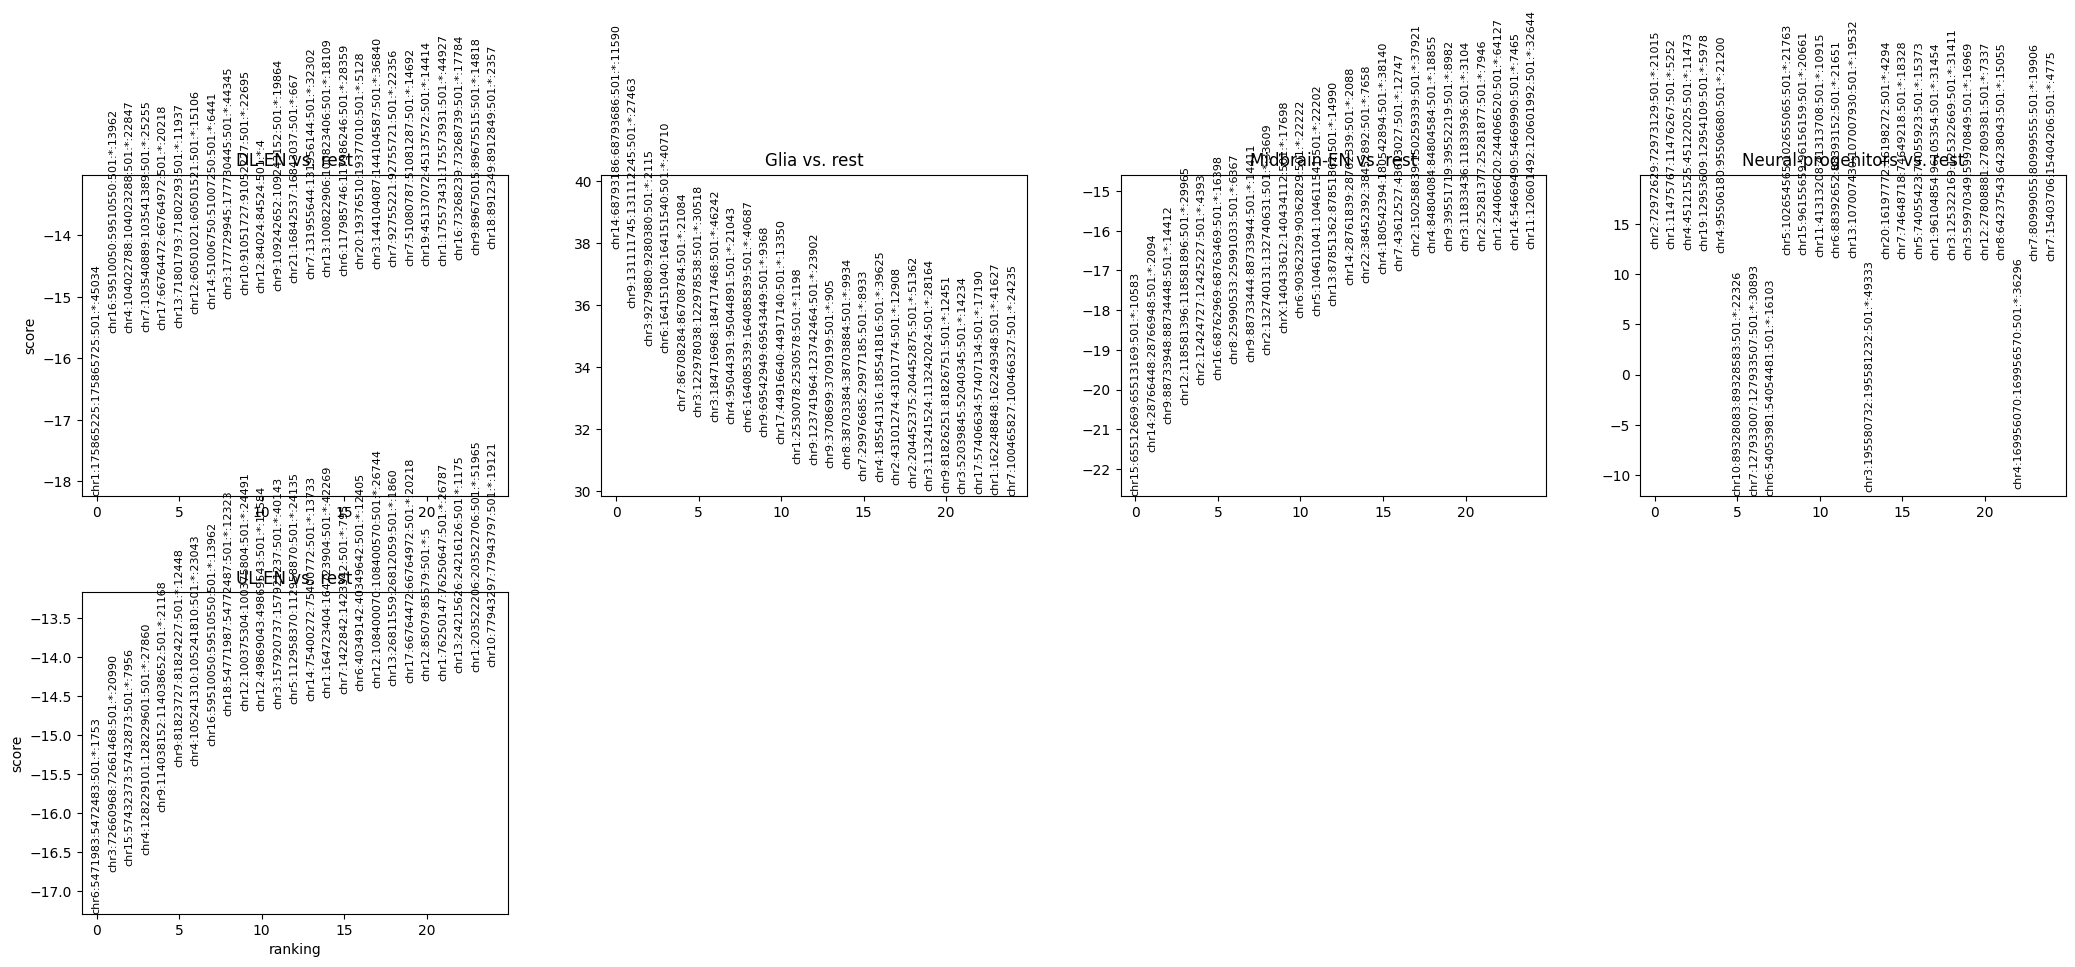

In [25]:
sc.tl.rank_genes_groups(caPeaks_agg_cd, groupby='cell_type', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(caPeaks_agg_cd, n_genes=25, sharey=False)

In [26]:
daps = sc.get.rank_genes_groups_df(caPeaks_agg_cd, group=cell_type, pval_cutoff=min_pval)
peaks_markers = set(daps['names'][0:n_top_markers])
daps

,names,scores,logfoldchanges,pvals,pvals_adj
0,chr1:175865225:175865725:501:*:45034,-18.235966,-3.121816,1.354714e-50,9.926708e-45
1,chr16:59510050:59510550:501:*:13962,-15.583673,-5.197972,7.390768e-39,7.736582e-34
2,chr4:104022788:104023288:501:*:22847,-15.580594,-3.672025,2.197218e-40,5.366728e-35
3,chr7:103540889:103541389:501:*:25255,-15.568914,-3.969718,2.383608e-39,4.366489e-34
4,chr17:66764472:66764972:501:*:20218,-15.536820,-4.408374,6.878074e-39,7.736582e-34
...,...,...,...,...,...
166428,chr13:52679008:52679508:501:*:9009,-3.078177,-1.719773,2.266538e-03,9.982466e-03
166429,chr1:66628926:66629426:501:*:24774,-3.078138,-1.381697,2.270688e-03,9.997490e-03
166430,chr14:68037875:68038375:501:*:11188,-3.077985,-1.561361,2.267923e-03,9.987393e-03
166431,chr6:110710065:110710565:501:*:26577,-3.077736,-1.824989,2.269876e-03,9.994882e-03


In [27]:
daps_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/differentially-accessible-peaks/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(daps_out_path)))

daps.to_csv(daps_out_path, sep='\t')

In [28]:
del caPeaks_agg_cd

## Peaks filter: intersecting w eQTLs

### Make eQTLs bed file

In [29]:
eqtls = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "eQTL_mapping/eSNPs_significant_all_celltypes_HVGs.tsv"),
                   sep='\t',
                   header=0,
                   index_col=21)
eqtls.columns

Index(['snp_id', 'p_value', 'beta', 'beta_se', 'empirical_feature_p_value',
       'feature_chromosome', 'feature_start', 'feature_end', 'gene_name',
       'n_samples', 'n_e_samples', 'alpha_param', 'beta_param', 'rho',
       'snp_chromosome', 'snp_position', 'assessed_allele', 'call_rate', 'maf',
       'hwe_p', 'feature_id', 'global_corrected_pValue',
       'global_corrected_pValue_BH', 'global_corrected_pValue_BF', 'celltype'],
      dtype='object')

In [30]:
eqtls

,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,gene_name,n_samples,...,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,global_corrected_pValue,global_corrected_pValue_BH,global_corrected_pValue_BF,celltype
QTL,,,,,,,,,,,,,,,,,,,,,
ENSG00000269376-chr13_112983450_T_C,chr13_112983450_T_C,0.000066,-0.364427,0.092665,0.000000e+00,13,113009671,113010319,NaN,277,...,112983450,C,1.0,0.044776,1.000000,ENSG00000269376,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000183463-chr13_27824764_C_T,chr13_27824764_C_T,0.047441,-0.089739,0.045430,0.000000e+00,13,27977717,27988693,URAD,277,...,27824764,C,1.0,0.089552,0.073438,ENSG00000183463,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000259182-chr15_101221494_A_C,chr15_101221494_A_C,0.202509,-0.088910,0.069866,0.000000e+00,15,101168530,101170821,NaN,277,...,101221494,A,1.0,0.044776,0.110206,ENSG00000259182,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286922-chr12_127567286_A_G,chr12_127567286_A_G,0.265404,-0.030918,0.027792,0.000000e+00,12,127486938,127533242,NaN,277,...,127567286,G,1.0,0.074627,1.000000,ENSG00000286922,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286246-chr12_129375924_C_G,chr12_129375924_C_G,0.949835,-0.000101,0.001608,4.101945e-163,12,129622929,129625366,NaN,277,...,129375924,C,1.0,0.089552,0.073438,ENSG00000286246,1.930191e-161,2.223254e-161,1.111627e-160,immature_EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250842-chr5_145190494_A_T,chr5_145190494_A_T,0.000033,0.535958,0.130797,1.828702e-02,5,145337932,145381670,NaN,310,...,145190494,A,1.0,0.316176,1.000000,ENSG00000250842,4.610052e-02,4.610052e-02,1.000000e+00,Differentiating_RG
ENSG00000267537-chr19_28873752_G_A,chr19_28873752_G_A,0.000285,-0.620958,0.172965,1.854836e-02,19,28602379,28648303,NaN,310,...,28873752,G,1.0,0.066176,0.246147,ENSG00000267537,4.669823e-02,4.669823e-02,1.000000e+00,Differentiating_RG
ENSG00000287056-chr6_168100952_C_G,chr6_168100952_C_G,0.001926,-0.216988,0.070509,1.932144e-02,6,168217032,168220262,NaN,310,...,168100952,C,1.0,0.102941,1.000000,ENSG00000287056,4.858106e-02,4.858106e-02,1.000000e+00,Differentiating_RG


In [31]:
eqtls['celltype'].unique()

array(['immature_EN', 'Stressed_Prog', 'IPC', 'Glia', 'UL-EN',
       'Midbrain_EN', 'Dividing_Glia', 'DL-EN', 'Interneurons',
       'Stressed_Neurons', 'Differentiating_RG'], dtype=object)

In [32]:
cell_type_alt

'DL-EN'

In [33]:
# Make eQTL bed file

eqtls_bed = eqtls[['snp_chromosome', 'snp_position', 'beta', 'celltype']].copy()

# Filter out 'Discard' marked cell-types
eqtls_bed = eqtls_bed[eqtls_bed['celltype'].isin(ct_map_alt['Discard'])].copy()

eqtls_bed['start'] = eqtls_bed['snp_position'] - 1 # Make index 0-based open
eqtls_bed['strand'] = '+'
eqtls_bed.reset_index(inplace=True)
eqtls_bed['chr'] = 'chr' + eqtls_bed['snp_chromosome'].astype(str)
eqtls_bed = eqtls_bed.rename(columns={'snp_position': 'end', 'QTL': 'id', 'beta': 'score'})

eqtls_bed = eqtls_bed[['chr', 'start', 'end', 'id', 'score', 'strand']].sort_values(by=['chr', 'start'], ascending=[True, True])
        
eqtls_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/eQTLs/{ct_map_id}/eQTLs_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(eqtls_bed_path)))

eqtls_bed.to_csv(eqtls_bed_path, sep='\t', header=False, index=False)

eqtls_bed

,chr,start,end,id,score,strand
516,chr1,31667956,31667957,ENSG00000203620-chr1_31667957_G_A,-0.362039,+
511,chr1,41152241,41152242,ENSG00000286668-chr1_41152242_C_G,-0.047192,+
510,chr1,41964567,41964568,ENSG00000044012-chr1_41964568_T_A,-0.015555,+
509,chr1,50418557,50418558,ENSG00000284645-chr1_50418558_G_C,-0.030638,+
515,chr1,51296414,51296415,ENSG00000227070-chr1_51296415_A_G,-0.411862,+
...,...,...,...,...,...,...
323,chr9,118704989,118704990,ENSG00000225050-chr9_118704990_A_T,-0.001100,+
115,chr9,129940361,129940362,ENSG00000196979-chr9_129940362_G_A,-0.002763,+
403,chr9,135546343,135546344,ENSG00000107147-chr9_135546344_AAGGCTGGCTTCTGA...,-0.401466,+
117,chr9,135617228,135617229,ENSG00000237339-chr9_135617229_C_T,-0.001345,+


### Make peaks bed file

In [34]:
peaks_bed = borgs_tile_mat.var[['chr', 'start', 'end', 'peak_name', 'score']].copy()
peaks_bed['start'] = peaks_bed['start'] - 1
peaks_bed['strand'] = '+'

peaks_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peaks/{ct_map_id}/{cell_type}.bed'

create_folder(os.path.dirname(os.path.abspath(peaks_bed_path)))

peaks_bed.to_csv(peaks_bed_path, sep='\t', header=False, index=False)

print(len(peaks_bed))
peaks_bed

732753


,chr,start,end,peak_name,score,strand
peak_name,,,,,,
chr1:804695:805195:501:*:1,chr1,804694,805195,chr1:804695:805195:501:*:1,3.01127,+
chr1:811018:811518:501:*:2,chr1,811017,811518,chr1:811018:811518:501:*:2,17.72120,+
chr1:817077:817577:501:*:3,chr1,817076,817577,chr1:817077:817577:501:*:3,19.46110,+
chr1:817816:818316:501:*:4,chr1,817815,818316,chr1:817816:818316:501:*:4,10.06330,+
chr1:819782:820282:501:*:5,chr1,819781,820282,chr1:819782:820282:501:*:5,2.71269,+
...,...,...,...,...,...,...
chrX:155891803:155892303:501:*:19674,chrX,155891802,155892303,chrX:155891803:155892303:501:*:19674,11.25430,+
chrX:155941826:155942326:501:*:19675,chrX,155941825,155942326,chrX:155941826:155942326:501:*:19675,9.46511,+
chrX:155956608:155957108:501:*:19676,chrX,155956607,155957108,chrX:155956608:155957108:501:*:19676,42.66500,+


### Peaks intersecting w eQTLs

In [35]:
try:
    result = subprocess.run([bedtools_bin, 'intersect' , '-a', peaks_bed_path, '-b', eqtls_bed_path, '-u'], text=True, capture_output=True)

    # with open(f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}_filt-eqtls.bed', 'w') as f:
        # f.write(result.stdout)

    peaks_eqtl = set([i.split('\t')[3] for i in result.stdout.split('\n')[:-1]])
    
except subprocess.CalledProcessError as e:
    
    print(f"Command failed with error: {e.stderr}")

### Peaks filter: close to eGenes

In [36]:
eGenes = set(eqtls.loc[~eqtls['gene_name'].isna(), 'gene_name'].unique())

In [37]:
len(eGenes)

1204

In [38]:
peaks_eGenes = set(borgs_tile_mat.var[borgs_tile_mat.var['nearest_gene'].isin(eGenes)].index)

len(peaks_eGenes)

32853

In [39]:
del borgs_tile_mat

# Cell-type level analysis

### Peak filter: HVPeaks

In [40]:
# Remove batches w with min cell nr
cell_counts_per_donor_batch = caPeaks_1ct.obs.groupby('batch').transform('size')
ca_1ct_batch_filtered = caPeaks_1ct[cell_counts_per_donor_batch >= 10, :].copy()
sum(cell_counts_per_donor_batch >= 10)

30183

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


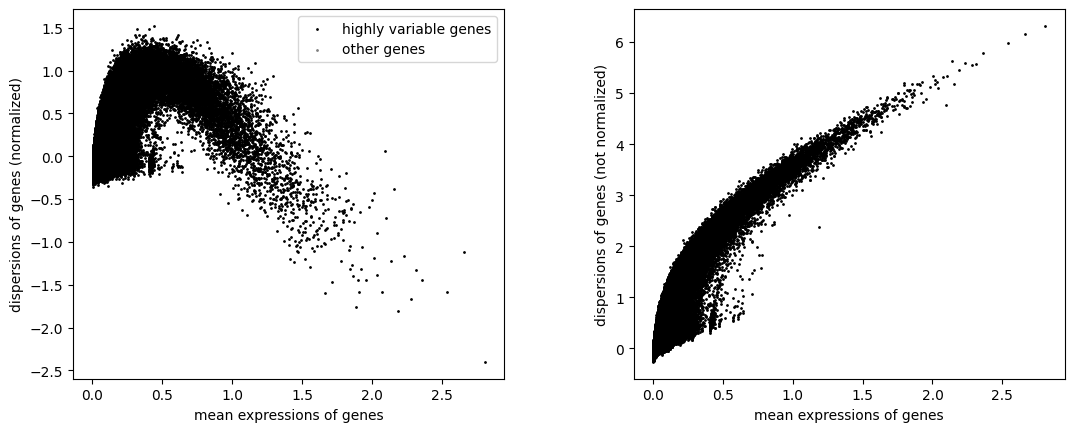

In [41]:
# Seurat (expect log)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat', batch_key='batch', n_top_genes=ca_1ct_batch_filtered.n_vars)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [42]:
# Extract top n HVPs
merge = pd.merge(ca_1ct_batch_filtered.var['means'].to_frame(),
              ca_1ct_batch_filtered.var['highly_variable_nbatches'].to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = pd.merge(merge,
              ca_1ct_batch_filtered.var['dispersions_norm'].abs().to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = merge[(merge['means'] > min_mean_acells) & (merge['means'] < max_mean_acells)]

merge = merge.sort_values(by=['highly_variable_nbatches', 'dispersions_norm'], ascending=[False, False])
peaks_hvp = set(merge[0:n_top_hvps].index)

In [43]:
# peaks_hvp = set(ca_1ct_batch_filtered.var[ca_1ct_batch_filtered.var['highly_variable']].index)

In [44]:
from scipy.sparse import issparse

# Convert sparse matrix to dense format if necessary
data_matrix = caPeaks_1ct.X.toarray() if issparse(caPeaks_1ct.X) else caPeaks_1ct.X

# Check for NaN values
print("Number of NaN values in data:", np.isnan(data_matrix).sum())

# Check for infinite values
print("Number of infinite values in data:", np.isinf(data_matrix).sum())

# Check for rows with all zeros (optimized for sparse matrices)
if issparse(caPeaks_1ct.X):
    zero_rows = np.array((caPeaks_1ct.X != 0).sum(axis=1)).flatten() == 0
else:
    zero_rows = np.sum(data_matrix == 0, axis=1) == data_matrix.shape[1]

print("Number of rows with all zero values:", zero_rows.sum())

Number of NaN values in data: 0


Number of infinite values in data: 0


Number of rows with all zero values: 0


In [45]:
del ca_1ct_batch_filtered

## Peaks filter: min mean across donors

In [46]:
agg_mean = agg_df.mean()

In [47]:
agg_mean.describe()

count    732753.000000
mean          0.007416
std           0.021250
min           0.000023
25%           0.000756
50%           0.001789
75%           0.005259
max           0.554685
dtype: float64

<Axes: title={'center': 'Peak mean across donors distr.'}, ylabel='#'>

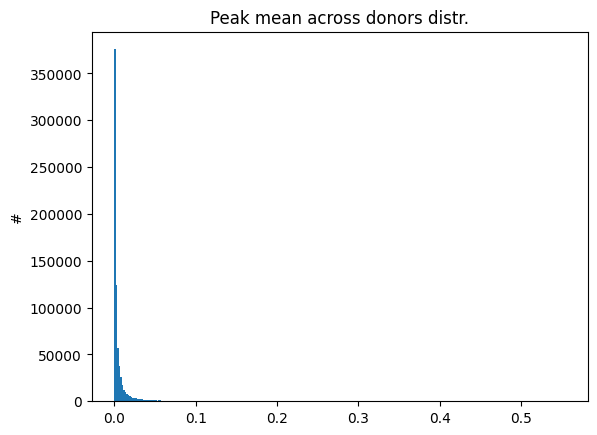

In [48]:
agg_mean.plot(kind='hist',
              bins=300, title="Peak mean across donors distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='#'>

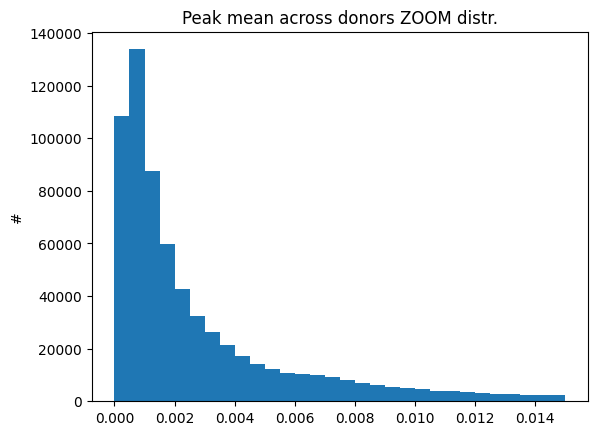

In [49]:
agg_mean.plot(kind='hist', 
              bins=np.linspace(0, 0.015, 31),
              title="Peak mean across donors ZOOM distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='Density'>

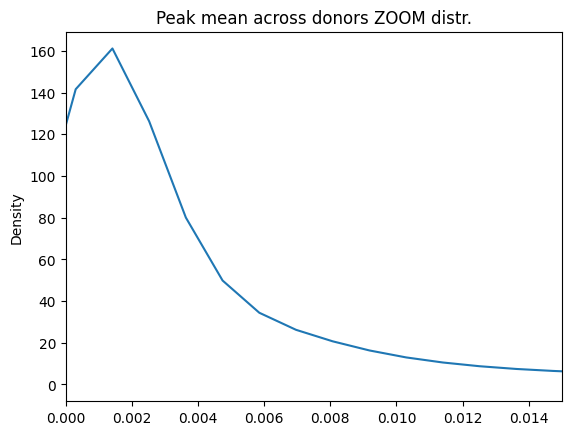

In [50]:
agg_mean.plot(kind='density',
              xlim=[0, 0.015],
              title="Peak mean across donors ZOOM distr.",
              xlabel="")

In [51]:
peaks_min_mean = set(agg_df.loc[:, agg_mean > min_mean_adonors].columns.tolist())

## Peaks filter: min donors with non-zero ca count

In [52]:
non0s = (agg_df != 0).mean()

non0s.describe()

count    732753.000000
mean          0.433151
std           0.163905
min           0.060606
25%           0.303030
50%           0.424242
75%           0.560606
max           0.954545
dtype: float64

<Axes: title={'center': 'Non-zero donor count distr.'}, ylabel='#'>

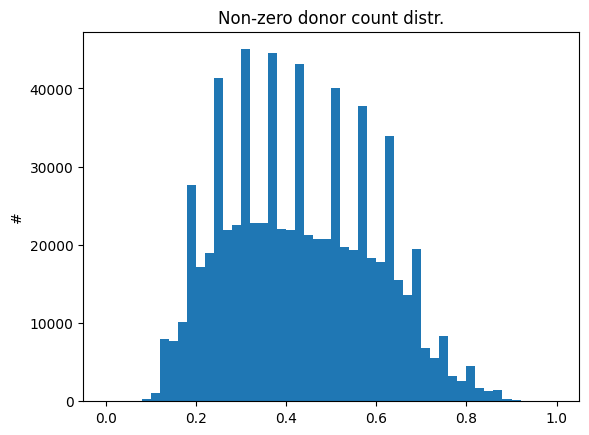

In [53]:
non0s.plot(kind='hist',
           bins=np.linspace(0, 1, 51),
           title="Non-zero donor count distr.",
           ylabel="#")

In [54]:
peaks_min_donors = set(agg_df.loc[:, non0s > min_donors].columns.to_list())

In [55]:
# Density of CA

non0 = np.count_nonzero(caPeaks_1ct_agg.X)
all_ = np.product(caPeaks_1ct_agg.X.shape)
general_ca_density = round(non0 / all_, 2)
print(f'General matrix density: {general_ca_density}')

General matrix density: 0.43


## Peaks filter: min peak score

In [56]:
peak_scores = caPeaks_1ct_agg.var['score']

In [57]:
peak_scores.describe()

count    732753.000000
mean         19.462772
std          28.571349
min           1.028790
25%           5.897420
50%          10.062700
75%          21.246000
max        1017.970000
Name: score, dtype: float64

<Axes: title={'center': 'Peak score distr.'}, ylabel='#'>

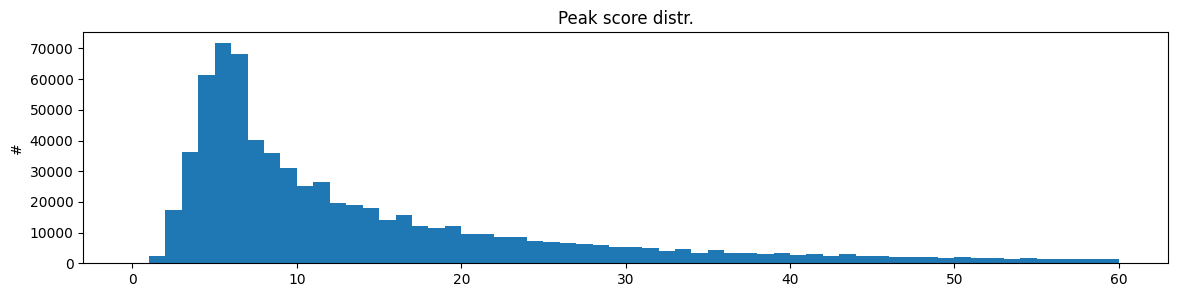

In [58]:
peak_scores.plot(kind='hist',
                 bins=np.linspace(0, 60, 61),
                 figsize=(14,3),
                 title="Peak score distr.",
                 ylabel="#")

In [59]:
peaks_min_score = set(caPeaks_1ct_agg.var[(caPeaks_1ct_agg.var['score'] >= min_score).tolist()].index.tolist())

In [60]:
del agg_df

## CA matrix: final peaks filtering step and export

In [61]:
print(f'Len peaks_hvp = {len(peaks_hvp)}\n' \
      f'peaks_hvp = {list(peaks_hvp)[0:4]}')

print(f'Len peaks_markers = {len(peaks_markers)}\n' \
      f'peaks_markers = {list(peaks_markers)[0:4]}')

print(f'Len peaks_eqtl = {len(peaks_eqtl)}\n' \
      f'peaks_eqtl = {list(peaks_eqtl)[0:4]}')

print(f'Len peaks_eGenes = {len(peaks_eGenes)}\n' \
      f'peaks_eGenes = {list(peaks_eGenes)[0:4]}')

print(f'Len peaks_min_mean = {len(peaks_min_mean)}\n' \
      f'peaks_min_mean = {list(peaks_min_mean)[0:4]}')

print(f'Len peaks_min_donors = {len(peaks_min_donors)}\n' \
      f'peaks_min_donors = {list(peaks_min_donors)[0:4]}')

print(f'Len peaks_min_score = {len(peaks_min_score)}\n' \
      f'peaks_min_score = {list(peaks_min_score)[0:4]}')

Len peaks_hvp = 10000
peaks_hvp = ['chr19:35702250:35702750:501:*:11537', 'chr6:136289115:136289615:501:*:32685', 'chr1:214602887:214603387:501:*:55903', 'chr6:116680838:116681338:501:*:28131']
Len peaks_markers = 10000
peaks_markers = ['chr10:28282255:28282755:501:*:7764', 'chr1:20400457:20400957:501:*:8812', 'chr6:164247021:164247521:501:*:40741', 'chr16:63067053:63067553:501:*:14532']
Len peaks_eqtl = 75
peaks_eqtl = ['chr20:31666653:31667153:501:*:6989', 'chr16:52029746:52030246:501:*:11603', 'chr8:60910072:60910572:501:*:14303', 'chr16:77315477:77315977:501:*:18836']
Len peaks_eGenes = 32853
peaks_eGenes = ['chr5:126138584:126139084:501:*:27429', 'chr2:172389930:172390430:501:*:43553', 'chr5:101754079:101754579:501:*:21633', 'chr3:140370721:140371221:501:*:35846']
Len peaks_min_mean = 343442
peaks_min_mean = ['chr15:58065494:58065994:501:*:8133', 'chr16:2485648:2486148:501:*:1614', 'chr1:37476533:37477033:501:*:15506', 'chr9:134995630:134996130:501:*:29548']
Len peaks_min_donors =

In [62]:
# Filter final peaks
final_peaks = list((peaks_hvp | peaks_markers | peaks_eqtl | peaks_eGenes) & (peaks_min_mean | peaks_min_donors | peaks_min_score)) # remove peaks_min_mean or peaks_min_donors

caPeaks_1ct_agg = caPeaks_1ct_agg[:, final_peaks].copy()

len(final_peaks)

52184

In [63]:
# Create CA matrix
ca_peaks_out = caPeaks_1ct_agg.to_df().T
ca_peaks_out = ca_peaks_out.rename_axis('peak_id')

In [64]:
len(ca_peaks_out.columns.tolist())

66

In [65]:
ca_donors = list(set(ca_peaks_out.columns.tolist()) - artifact_donors) # Should be redundand
len(ca_donors)

66

In [66]:
ca_peaks_out = ca_peaks_out[ca_donors]

print(ca_peaks_out.shape)
ca_peaks_out

(52184, 66)


,SAMEA2658084,SAMEA2627566,SAMEA3962524,SAMEA2625592,SAMEA2707499,SAMEA3963885,SAMEA2682671,SAMEA2698309,SAMEA3854308,SAMEA2613912,...,SAMEA2658107,SAMEA3962624,SAMEA3485962,SAMEA2536416,SAMEA2698315,SAMEA2518322,SAMEA2547622,SAMEA3853161,SAMEA3974247,SAMEA3973848
peak_id,,,,,,,,,,,,,,,,,,,,,
chr5:126138584:126139084:501:*:27429,0.000841,0.017759,0.001296,0.0,0.000000,0.000694,0.000000,0.003183,0.000000,0.003181,...,0.002101,0.000000,0.0,0.000000,0.0,0.000000,0.001228,0.003856,0.000000,0.003087
chr1:20400457:20400957:501:*:8812,0.000611,0.001504,0.003887,0.0,0.000000,0.002491,0.000000,0.011845,0.000000,0.002796,...,0.003189,0.007074,0.0,0.007086,0.0,0.000000,0.002154,0.015874,0.002073,0.004245
chr1:214602887:214603387:501:*:55903,0.111272,0.125984,0.144821,0.0,0.285077,0.134633,0.626039,0.114789,0.074393,0.114844,...,0.111780,0.095497,0.0,0.187024,0.0,0.087855,0.122179,0.124307,0.109059,0.123022
chr11:73307357:73307857:501:*:19718,0.163055,0.134217,0.127356,0.0,0.138192,0.153779,1.252079,0.145396,0.215312,0.145491,...,0.087721,0.215559,0.0,0.154132,0.0,0.332730,0.134230,0.145593,0.120892,0.130109
chr2:172389930:172390430:501:*:43553,0.000000,0.000000,0.000000,0.0,0.000000,0.000482,0.000000,0.000000,0.000000,0.000489,...,0.000562,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:41568646:41569146:501:*:10834,0.000900,0.000742,0.001486,0.0,0.000000,0.001264,0.000000,0.003345,0.000000,0.003549,...,0.002377,0.000000,0.0,0.004795,0.0,0.000000,0.002191,0.004066,0.002789,0.002246
chr7:156640424:156640924:501:*:38531,0.184668,0.187351,0.209962,0.0,0.204784,0.163555,0.000000,0.191832,0.387177,0.151309,...,0.138631,0.140900,0.0,0.165162,0.0,0.136879,0.159032,0.170260,0.143890,0.160004
chr1:56784892:56785392:501:*:21666,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000143,...,0.000522,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000942


In [67]:
# Export peak chromatin accessibility
ca_peaks_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_ca/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_peaks_out_path)))

ca_peaks_out.round(6).to_csv(ca_peaks_out_path, sep='\t')

### CA matrix stats

In [68]:
_, mean_cells_donor, std_cells_donor, _, _, _, _, _ = caPeaks_1ct.obs.groupby('donor_id').size().describe()

donor_batch = caPeaks_1ct.obs.groupby(['donor_id', 'batch']).size()
donor_batch = donor_batch[donor_batch != 0]
n_donor_batches, mean_cells_donor_batch, std_cells_donor_batch, _, _, _, _, _ = donor_batch.describe()
n_donor_batches = int(n_donor_batches)

In [69]:
# Stats

stats_out_path = f"results/datasets/{DATASET_ID}/matrix-eQTL/{ct_map_id}/io_stats.tsv"

create_folder(os.path.dirname(os.path.abspath(stats_out_path)))

with open(stats_out_path, 'a') as f:
        
    msg = f'\n{RUN_ID}\t' \
            f'{cell_type}\t' \
            f'{general_ca_density}\t' \
            f'{n_cells}\t' \
            f'{n_donors}\t' \
            f'{mean_cells_donor}\t' \
            f'{std_cells_donor}\t' \
            f'{n_donor_batches}\t' \
            f'{mean_cells_donor_batch}\t' \
            f'{std_cells_donor_batch}\t' \
            f'{n_peaks_og}\t' \
            f'{n_peaks_min_cells}\t' \
            f'{n_peaks_post_min_cells}\t' \
            f'{len(peaks_hvp)}\t' \
            f'{len(peaks_markers)}\t' \
            f'{len(peaks_eqtl)}\t' \
            f'{len(peaks_eGenes)}\t' \
            f'{len(peaks_min_mean)}\t' \
            f'{len(peaks_min_donors)}\t' \
            f'{len(peaks_min_score)}\t' \
            f'{ca_peaks_out.shape[0]}\t' \
            f'{ca_peaks_out.shape[1]}'

    f.write(msg)
    print(msg)


meqtl_sep30_ref2_approach_2024-09-12	DL-EN	0.43	30210	66	457.72727272727275	651.2018131106526	277	109.06137184115524	165.98701228962423	736845	4092	732753	10000	10000	75	32853	343442	641862	732753	52184	66


In [70]:
del ca_peaks_out
del caPeaks_1ct

# COV: peak locations

In [71]:
peak_locs = caPeaks_1ct_agg.var[['peak_name', 'chr', 'start', 'end']].copy()
peak_locs['start'] = peak_locs['start'] - 1

peak_locs

,peak_name,chr,start,end
peak_name,,,,
chr5:126138584:126139084:501:*:27429,chr5:126138584:126139084:501:*:27429,chr5,126138583,126139084
chr1:20400457:20400957:501:*:8812,chr1:20400457:20400957:501:*:8812,chr1,20400456,20400957
chr1:214602887:214603387:501:*:55903,chr1:214602887:214603387:501:*:55903,chr1,214602886,214603387
chr11:73307357:73307857:501:*:19718,chr11:73307357:73307857:501:*:19718,chr11,73307356,73307857
chr2:172389930:172390430:501:*:43553,chr2:172389930:172390430:501:*:43553,chr2,172389929,172390430
...,...,...,...,...
chr4:41568646:41569146:501:*:10834,chr4:41568646:41569146:501:*:10834,chr4,41568645,41569146
chr7:156640424:156640924:501:*:38531,chr7:156640424:156640924:501:*:38531,chr7,156640423,156640924
chr1:56784892:56785392:501:*:21666,chr1:56784892:56785392:501:*:21666,chr1,56784891,56785392


In [72]:
peak_locs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(peak_locs_path)))

peak_locs.to_csv(peak_locs_path, sep='\t', index=False)

In [73]:
del peak_locs

# COV: CA PCs

In [74]:
sc.pp.pca(caPeaks_1ct_agg) # Filtered for final peak set

In [75]:
ca_pcs = pd.DataFrame(caPeaks_1ct_agg.obsm['X_pca'][:, 0:n_ca_PCs]).set_index(caPeaks_1ct_agg.obs_names)
ca_pcs.columns = [f'caPC_{str(i)}' for i in range(1, n_ca_PCs + 1)]
ca_pcs = ca_pcs.T
ca_pcs = ca_pcs.rename_axis('id')

In [76]:
# ! Important that this doesn't change the sample nr! 2 cells above
ca_pcs = ca_pcs[ca_donors]

print(ca_pcs.shape)
ca_pcs

(5, 66)


,SAMEA2658084,SAMEA2627566,SAMEA3962524,SAMEA2625592,SAMEA2707499,SAMEA3963885,SAMEA2682671,SAMEA2698309,SAMEA3854308,SAMEA2613912,...,SAMEA2658107,SAMEA3962624,SAMEA3485962,SAMEA2536416,SAMEA2698315,SAMEA2518322,SAMEA2547622,SAMEA3853161,SAMEA3974247,SAMEA3973848
id,,,,,,,,,,,,,,,,,,,,,
caPC_1,-1.206302,-1.123541,-1.120828,-1.307232,-1.174783,-1.198674,-0.713471,-1.168216,-1.058936,-1.143942,...,-1.175286,-1.043007,-1.224685,-1.120146,-1.020646,-1.192508,-1.153459,-1.139124,-1.207398,-1.150675
caPC_2,-1.033910,-1.095865,-1.073540,-0.863685,-1.089210,-1.114043,-0.719299,-1.125796,-0.912586,-1.109430,...,-1.053920,-1.030851,-1.728867,-1.088368,-1.236917,-1.021688,-1.017084,-1.013066,-1.052697,-1.080097
caPC_3,-0.933657,-0.808011,-0.741912,55.746735,-0.908932,-0.837912,-0.081215,-0.807573,-0.551195,-0.821067,...,-0.980839,-0.780061,-1.139002,-0.759426,-1.041873,-0.706000,-0.816367,-0.793026,-0.851123,-0.853823
caPC_4,-0.682966,-0.652874,-0.580082,1.056066,-0.755131,-0.661317,-0.999306,-0.628505,-0.839812,-0.641523,...,-0.662657,-0.630446,-0.615319,-0.613097,-0.457146,-0.519761,-0.608557,-0.568100,-0.670962,-0.641437
caPC_5,-1.001538,-1.064805,-1.016262,3.137164,-0.997620,-0.974628,-1.180444,-1.020691,-0.912581,-1.027333,...,-0.878062,-0.994843,-1.512019,-1.042256,-1.469091,-1.165376,-0.963017,-1.018775,-1.003241,-0.978461


In [77]:
ca_pcs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/ca_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_pcs_path)))

ca_pcs.to_csv(ca_pcs_path, sep='\t')

In [78]:
del ca_pcs
del caPeaks_1ct_agg

# COV: Population structure

In [79]:
gt_pcs = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "Genotypes/GT_PCs.tsv"), sep="\t", index_col=0)
gt_pcs_matrixQTL = gt_pcs.T
gt_pcs_matrixQTL = gt_pcs_matrixQTL.rename_axis('id')
gt_pcs_matrixQTL = gt_pcs_matrixQTL[ca_donors]

print(gt_pcs_matrixQTL.shape)
gt_pcs_matrixQTL

(20, 66)


iid,SAMEA2658084,SAMEA2627566,SAMEA3962524,SAMEA2625592,SAMEA2707499,SAMEA3963885,SAMEA2682671,SAMEA2698309,SAMEA3854308,SAMEA2613912,...,SAMEA2658107,SAMEA3962624,SAMEA3485962,SAMEA2536416,SAMEA2698315,SAMEA2518322,SAMEA2547622,SAMEA3853161,SAMEA3974247,SAMEA3973848
id,,,,,,,,,,,,,,,,,,,,,
PC1,-7.199219,-539.717350,12.186271,-36.099750,36.567543,-45.389390,16.612453,-587.087340,15.455708,-44.876938,...,-3.758722,-39.436108,26.002121,-141.934390,-28.362892,0.094868,-17.051203,-26.086426,2.513582,-37.060190
PC2,13.413182,-454.769070,42.351612,69.155190,24.418850,578.792850,36.950134,367.275100,43.419895,-26.285961,...,-17.553230,11.223527,45.160843,-963.927860,-27.927677,28.659481,15.449395,12.337655,42.838642,38.517700
PC3,46.895866,-640.132000,10.103840,54.365560,56.386528,-521.950900,-0.269906,587.046800,29.958840,-132.768070,...,-21.497366,7.243265,15.704102,-71.293526,1.648885,20.669409,-4.636946,8.423677,20.748500,17.455568
PC4,-19.546944,496.013460,-94.013070,8.240096,49.088190,-901.205300,24.004366,372.022800,-21.306501,-639.104000,...,-10.106815,19.611492,-34.477210,18.946665,-32.976494,9.481113,-16.699575,-15.730290,-6.323660,-4.302910
PC5,-9.918574,742.706240,-3.526762,-5.430482,-1.617828,563.941200,28.637024,49.229893,11.136854,-85.408226,...,-1.862093,16.133036,-20.587145,-371.363400,-31.880617,22.285526,47.738790,12.673084,-47.334480,-23.714428
PC6,6.438612,-345.228760,5.925176,7.309116,-71.204760,270.644130,-51.300888,-182.055220,-12.994849,-492.477700,...,10.962170,-32.406673,-7.275044,-577.124300,-43.034910,-30.922153,-40.836580,-49.799580,-32.809708,-26.442297
PC7,23.455002,-119.798935,-43.594402,-14.493244,4.270656,269.105530,-23.499296,-386.220730,-0.985342,156.371300,...,7.909484,23.316786,3.188169,1123.644800,-18.378374,-16.092543,-20.985556,-11.844399,-3.031651,-12.364730
PC8,14.720870,939.068900,-6.027317,-20.599740,-3.997136,-393.916500,-45.816135,-129.463040,-20.355007,-407.644650,...,32.048443,-19.541563,0.363527,-458.672880,36.437107,-1.781297,-10.358272,18.833464,2.906827,32.569214
PC9,-2.595212,529.354800,17.676556,6.205075,4.609481,-186.866290,20.013197,-532.290700,-37.755750,1240.363200,...,40.589954,-9.519834,48.655170,-610.459530,2.044739,21.162674,-21.179520,23.225570,-10.186135,-43.781162


In [80]:
parent_dir = "data/datasets/hca_brain-organoids_processed/covariates/"

if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

In [81]:
gt_pcs_matrixQTL_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/genotype_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(gt_pcs_matrixQTL_path)))

gt_pcs_matrixQTL.to_csv(gt_pcs_matrixQTL_path, sep='\t')

In [82]:
del gt_pcs
del gt_pcs_matrixQTL

# Genotype

In [83]:
gt = pd.read_csv('data/datasets/hca_brain-organoids_processed/covariates/genotype.tsv', sep='\t', header=0, index_col=0).rename_axis('snp_id')
gt = gt.rename(index=lambda x: 'chr' + str(x))

In [84]:
snps_set = list(set(gt.index))

In [85]:
gt = gt[ca_donors]
gt

,SAMEA2658084,SAMEA2627566,SAMEA3962524,SAMEA2625592,SAMEA2707499,SAMEA3963885,SAMEA2682671,SAMEA2698309,SAMEA3854308,SAMEA2613912,...,SAMEA2658107,SAMEA3962624,SAMEA3485962,SAMEA2536416,SAMEA2698315,SAMEA2518322,SAMEA2547622,SAMEA3853161,SAMEA3974247,SAMEA3973848
snp_id,,,,,,,,,,,,,,,,,,,,,
chr1_89599_A_T,NaN,2.0,0.0,2.0,0.0,NaN,0.0,2.0,2.0,2.0,...,NaN,2.0,2.0,1.0,1.0,NaN,2.0,NaN,NaN,2.0
chr1_94986_C_T,NaN,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,...,0.0,2.0,2.0,1.0,2.0,NaN,2.0,NaN,NaN,2.0
chr1_94996_A_AT,NaN,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,NaN,2.0,NaN,NaN,2.0
chr1_95068_G_A,2.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
chr1_96305_C_T,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_50780959_T_C,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
chr22_50781276_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
chr22_50783303_T_C,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


In [86]:
gt_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/{ct_map_id}/genotype_NA_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(gt_path)))

gt.to_csv(gt_path, sep='\t', na_rep='NaN')

In [87]:
del gt

# SNP locations

In [88]:
snps = pd.read_csv("data/datasets/hca_brain-organoids_processed/covariates/genotype.vcf",
                   sep="\t",
                   comment="#",
                   header=None,
                   names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMEA2536416", "SAMEA3854313", "SAMEA3853161", "SAMEA3966392", "SAMEA2625592", "SAMEA2698309", "SAMEA3962624", "SAMEA3965165", "SAMEA2595426", "SAMEA3962389", "SAMEA3973854", "SAMEA3847031", "SAMEA2547622", "SAMEA3854308", "SAMEA3964906", "SAMEA2536410", "SAMEA3735541", "SAMEA2590621", "SAMEA2698315", "SAMEA2445784", "SAMEA3973848", "SAMEA3962524", "SAMEA3485962", "SAMEA2609965", "SAMEA3851971", "SAMEA4089454", "SAMEA2613912", "SAMEA3963885", "SAMEA3963884", "SAMEA2613897", "SAMEA4089453", "SAMEA3851966", "SAMEA3974241", "SAMEA4343052", "SAMEA3962619", "SAMEA3853122", "SAMEA3974015", "SAMEA2518325", "SAMEA2433566", "SAMEA2459959", "SAMEA2675459", "SAMEA2682671", "SAMEA2645805", "SAMEA2711371", "SAMEA2593858", "SAMEA2445790", "SAMEA2518322", "SAMEA2547619", "SAMEA2627577", "SAMEA2547637", "SAMEA3977051", "SAMEA2445779", "SAMEA2609971", "SAMEA3974247", "SAMEA2658107", "SAMEA3754205", "SAMEA2547644", "SAMEA2678742", "SAMEA2474454", "SAMEA2627566", "SAMEA2518334", "SAMEA3967410", "SAMEA2536404", "SAMEA2627578", "SAMEA2518324", "SAMEA3968753", "SAMEA2547899", "SAMEA3754201", "SAMEA2570435", "SAMEA2658084", "SAMEA4451098", "SAMEA2678738", "SAMEA2547633", "SAMEA2609972", "SAMEA2707499", "SAMEA2555017", "SAMEA2420640", "SAMEA4451109", "SAMEA3448738", "SAMEA2627141", "SAMEA3485958", "SAMEA2536413", "SAMEA2464819", "SAMEA2627567", "SAMEA2645814"],
                   index_col=False
                  )

snps = snps[['ID', 'CHROM', 'POS']].rename(columns={'ID': 'snp_id', 'CHROM': 'chr', 'POS': 'pos'})
snps = snps.set_index('snp_id')

In [89]:
snps = snps.loc[snps_set, :].groupby(level=0).first() # There are repeated indexes in snps. Take the first one
snps

,chr,pos
snp_id,,
chr10_100000235_C_T,chr10,100000235
chr10_100000943_G_A,chr10,100000943
chr10_100000979_T_C,chr10,100000979
chr10_100002330_AAAAG_A,chr10,100002330
chr10_100002628_A_C,chr10,100002628
...,...,...
chr9_99997250_C_T,chr9,99997250
chr9_99997408_T_TTTTC,chr9,99997408
chr9_99998141_T_C,chr9,99998141


In [90]:
snps_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/snp_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(snps_path)))

snps.to_csv(snps_path, sep='\t')

In [91]:
del snps